## This notebook explores learned policies from the policies agents:

In [176]:
import sys
import os 
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from learning.collections_env.collections_env import CollectionsEnv
from learning.utils.wrappers import DiscretizedActionWrapper, StateNormalization
from learning.policies.dqn import DQNAgent, DefaultConfig
from learning.utils import misc

import os
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K

from IPython.display import HTML, clear_output

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"



In [177]:
log_path = os.path.join(misc.RESOURCE_ROOT, 'models', 'DDQN')
logs = os.listdir(log_path)
logs

['20200610-232039', '20200610-232703']

In [178]:
models = os.listdir(os.path.join(misc.RESOURCE_ROOT, 'models', 'DDQN', logs[-1]))
actions_bins = np.load(os.path.join(misc.RESOURCE_ROOT, 'models', 'DDQN', logs[-1], 'action_bins.npy'))

In [179]:
# actions_bins = np.array([0, 0.1, 1])
# actions_bins = np.array([0, 0.2])
# actions_bins = np.array([0, 0.5])
n_actions = len(actions_bins)
c_env = CollectionsEnv(continuous_reward=False)
environment = DiscretizedActionWrapper(c_env, actions_bins)
environment = StateNormalization(environment)

New action space: Discrete(3)


c:\users\majke\anaconda3\envs\tf2-gpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [180]:
config = DefaultConfig()
agent = DQNAgent(environment, 'DDQN', training=False, config=DefaultConfig())
agent.load(os.path.join(misc.RESOURCE_ROOT, 'models', 'DDQN', logs[-1], 'main_net.h5'))

In [181]:
w_points = 60
l_points = 60

w_normalized = np.linspace(0, 1, w_points)
l_normalized = np.linspace(0, 1, l_points)
l = np.linspace(environment.observation_space.low[0], environment.observation_space.high[0], l_points)
w = np.linspace(environment.observation_space.low[1], environment.observation_space.high[1], w_points)
wwn, lln = np.meshgrid(w_normalized, l_normalized)
ww, ll = np.meshgrid(w, l)
z = np.zeros_like(ww)
p = np.zeros_like(ww)
for i, xp in enumerate(w_normalized):
    for j, yp in enumerate(l_normalized):
        fixed_obs = np.array([yp, xp])
        z[j, i] = np.amax(agent.main_net.predict_on_batch(fixed_obs[None, :]))
        p[j, i] = environment.action(np.argmax(agent.main_net.predict_on_batch(fixed_obs[None,:])))

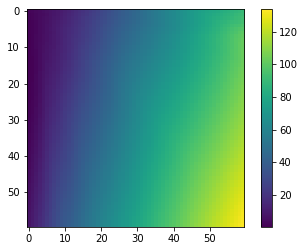

In [182]:
fig, ax = plt.subplots()
im = ax.imshow(z)
fig.colorbar(im)

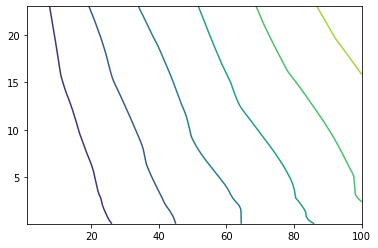

In [183]:
plt.contour(ww, ll, z)

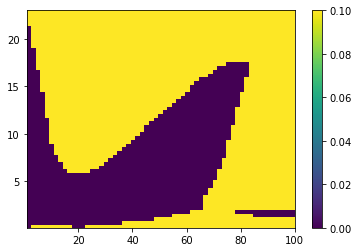

In [184]:
plt.pcolor(ww, ll, p)
plt.colorbar()
plt.show()

elementary check

In [185]:
fixed_obs = np.array([0.1, 100])
obs = environment.observation(fixed_obs)
agent.main_net.predict_on_batch(obs[None,:])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[88.18223, 89.26384, 87.64755]], dtype=float32)>

# lets value this policy:

In [186]:
rewards = agent.evaluate(1000)

Avg. reward over 1000 episodes: 75.7790


[INFO] [2020-06-10 23:39:31,200] [AAV] - Instantiated @ AAV


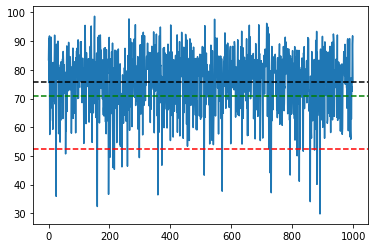

In [187]:
from dcc import AAV, Parameters
p = Parameters()
aav = AAV(p)

plt.plot(rewards)
plt.axhline(np.mean(rewards), color='black', linestyle='--')
plt.axhline(-aav.u(0.11, 100), color='red', linestyle='--')
plt.axhline(-aav.u(0.11 + 1, 100) - 1*p.c, color='green', linestyle='--')

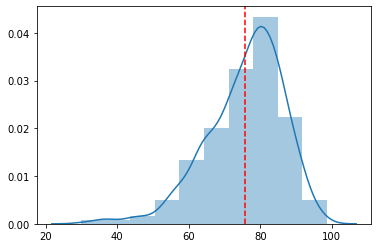

In [188]:
import seaborn as sns
fig, ax = plt.subplots()
sns.distplot(rewards, ax=ax, bins=10)
ax.axvline(np.mean(rewards), color='red', linestyle='--')
# ax.axvline(u, color='green', linestyle='--')

In [161]:
# agent.evaluate(100)

In [40]:
rewards = []
w_states = []
l_states = []
actions = []
for i in range(500):
    episode_reward = 0
    done = False
    state = environment.reset()
    while not done:
        # action = np.argmax(agent.main_net.predict_on_batch(state[None,:]))
        action, q = agent.get_action(state, epsilon=0.0)
        # action = 0
        actions.append(action)
        state, reward, done, _ = environment.step(action)
        episode_reward += reward
        converted_state = environment.convert_back(state)
        w_states.append(converted_state[1])
        l_states.append(converted_state[0])
        if episode_reward>100:
            break
        if done:
            rewards.append(episode_reward)
        

In [41]:
episode_reward

104.0699435064402

[INFO] [2020-06-10 16:14:49,422] [AAV] - Instantiated @ AAV


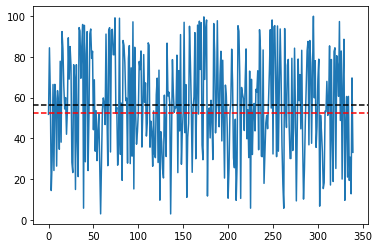

In [42]:
#plt.plot(results['REINFORCE AB'])
from dcc import AAV, Parameters
p = Parameters()
aav = AAV(p)

plt.plot(rewards)
plt.axhline(np.mean(rewards), color='black', linestyle='--')
plt.axhline(-aav.u(0.11, 100), color='red', linestyle='--')

Statespace path

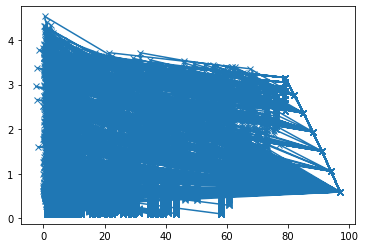

In [20]:
plt.plot(w_states, l_states, marker='x')

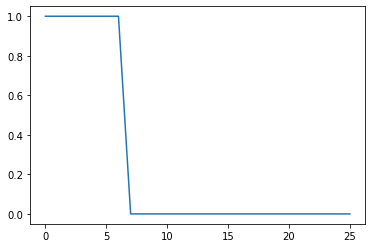

In [40]:
plt.plot(actions)

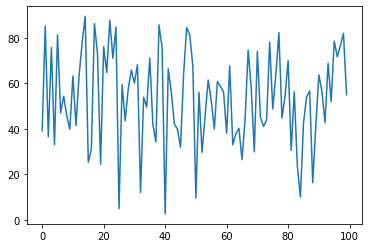

In [32]:
plt.plot(rewards)

Test policy that separates linearly the statespace by y=x

In [34]:
def dummy_policy(state):
    if state[1] > state[0]:
        return 0
    else:
        return 1

In [40]:
rewards = []
w_states = []
l_states = []
actions = []
for i in range(1000):
    episode_reward = 0
    done = False
    state = environment.reset()
    while not done:
        action = dummy_policy(state)
        actions.append(action)
        state, reward, done, _ = environment.step(action)
        episode_reward += reward
        converted_state = environment.convert_back(state)
        w_states.append(converted_state[1])
        l_states.append(converted_state[0])
        if done:
            rewards.append(episode_reward)

[INFO] [2020-06-02 23:47:54,724] [AAV] - Instantiated @ AAV


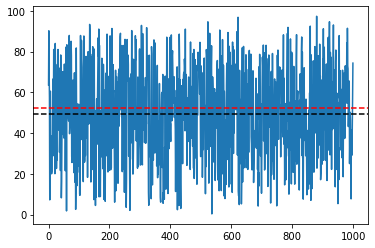

In [41]:
from dcc import AAV, Parameters
p = Parameters()
aav = AAV(p)

plt.plot(rewards)
plt.axhline(np.mean(rewards), color='black', linestyle='--')
plt.axhline(-aav.u(0.11, 100), color='red', linestyle='--')

In [37]:
w_points = 60
l_points = 60

w_normalized = np.linspace(0, 1, w_points)
l_normalized = np.linspace(0, 1, l_points)
l = np.linspace(environment.observation_space.low[0], environment.observation_space.high[0], l_points)
w = np.linspace(environment.observation_space.low[1], environment.observation_space.high[1], w_points)
wwn, lln = np.meshgrid(w_normalized, l_normalized)
ww, ll = np.meshgrid(w, l)
z = np.zeros_like(ww)
p = np.zeros_like(ww)
for i, xp in enumerate(w_normalized):
    for j, yp in enumerate(l_normalized):
        fixed_obs = np.array([yp, xp])
        z[j, i] = dummy_policy(fixed_obs)

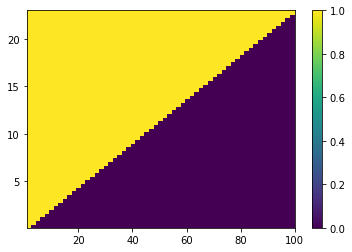

In [39]:
plt.pcolor(ww, ll,z)
plt.colorbar()
plt.show()

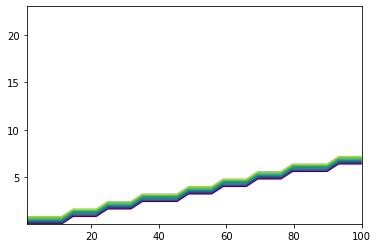

In [193]:
plt.contour(ww, ll, p)

<a list of 5 text.Text objects>

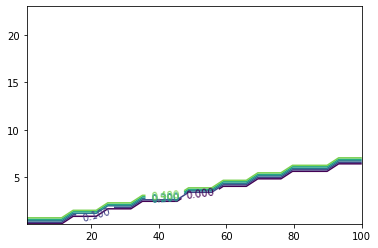

In [194]:
fig, ax = plt.subplots()

CS = ax.contour(ww, ll, p, levels=actions_bins.shape[0])

ax.clabel(CS, CS.levels, inline=True)

In [127]:
environment.observation((np.array([10, 100])))

array([0.43072846, 0.99      ])

In [156]:
environment.action(np.argmax(agent.main_net.predict_on_batch(environment.observation((np.array([0, 40])))[None,:])))

0.5

In [129]:
agent.main_net.predict_on_batch(environment.observation((np.array([10, 100])))[None,:])

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.00869119,  0.03472864, -0.04359293,  0.03921073]],
      dtype=float32)>

Too large rewards

In [13]:
for i in range(500):
    rewards = []
    w_states = []
    l_states = []
    actions = []
    running_rew = []
    episode_reward = 0
    done = False
    state = environment.reset()
    while not done:
        # action = np.argmax(agent.main_net.predict_on_batch(state[None,:]))
        action, q = agent.get_action(state, epsilon=0.0)
        # action = 0
        actions.append(action)
        state, reward, done, _ = environment.step(action)
        episode_reward += reward
        converted_state = environment.convert_back(state)
        w_states.append(converted_state[1])
        l_states.append(converted_state[0])
        running_rew.append(reward)
        if done:
            rewards.append(episode_reward)
    if episode_reward > 100:
            break
print(episode_reward)

54.01054076222942


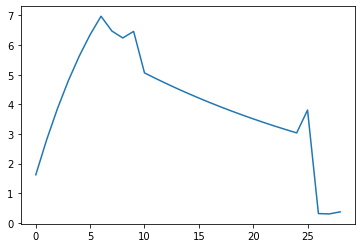

In [49]:
plt.plot(running_rew)

In [54]:
sum(running_rew)

115.5368299542362

In [12]:
plt.plot(w_states, l_states, marker='x')

NameError: name 'w_states' is not defined

In [55]:
running_rew

[1.6243811969741249,
 2.8061901892932894,
 3.8636767974060824,
 4.803207048258652,
 5.6308533981403865,
 6.35240742964039,
 6.973392228235554,
 6.47505871622246,
 6.240895813849036,
 6.461672126562987,
 5.062273813660349,
 4.879375343527313,
 4.70327898676048,
 4.5337313977754565,
 4.370488359476673,
 4.213314667512129,
 4.061984015508029,
 3.9162788812766496,
 3.775989618611022,
 3.640913960833701,
 3.5108577182509793,
 3.3856338856776342,
 3.265062157963559,
 3.148969236897277,
 3.037188155297534,
 3.8073140988546736,
 0.3152212468741361,
 0.30394710502683453,
 0.3732723598688317]

In [21]:
model5K.layer1.keras_api.call_and_return_all_conditional_losses(obs)

ValueError: Could not find matching function to call loaded from the SavedModel. Got:
  Positional arguments (1 total):
    * Tensor("inputs:0", shape=(2,), dtype=float32)
  Keyword arguments: {}

Expected these arguments to match one of the following 0 option(s):



In [12]:
tf.keras.models.load_model('dqn_5000e')

AttributeError: '_UserObject' object has no attribute 'call_and_return_conditional_losses'